** Final project code **

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import pandas as pd
import pygsp as pg
import matplotlib.pylab as plt

In [38]:
from load_and_preprocessing import load_data_and_filter_members, assign_party_to_names
from helpers import label_to_numeric, get_lap_eigendecomp, visualize_node_loyalty, visualize_modularity, visualize_party_orientation, make_signal
from network_analysis import compute_community_loyalty, detect_partitions, compute_modularity, centralities
from conseil_national_evolution import create_evolution_features_v1

In [7]:
# Use load_data_and_filter_members to create adjacency for any file from any legislature
# Example 
leg='49'
from_date = '01_01_2012'
to_date = '31_12_2012'
adjacency, node_index, sum_na_per_row = load_data_and_filter_members('../data/abdb-de-all-affairs-'+leg+'-0.csv',
                                                                     start_date=from_date, end_date=to_date,
                                                                     filter_method='number_NA',cutoff=10,ret_transf=False)

(Nbr. of councillors, nbr. of votes) before filter: (204, 419)
(Nbr. of councillors, nbr. of votes) after filter: (194, 418)


Assigning parties to the councillors from the dataset loaded above:

In [8]:
name_with_party = assign_party_to_names('../data/Ratsmitglieder_1848_FR.csv', node_index)
print(name_with_party.to_string())

         Counc_Id                  CouncillorName PartyAbbreviation
node_id                                                            
0             490              Lustenberger Ruedi               PDC
1            4025              Büchel Roland Rino               UDC
2             504                Rossini Stéphane               PSS
3            3922                   Favre Laurent               PLR
4            4092                    Poggia Mauro               MCR
5            1104                   Büchler Jakob               PDC
6            3911                      Voruz Eric               PSS
7            1295             Graf-Litscher Edith               PSS
8            4052                   Ritter Markus               PDC
9            3876                Estermann Yvette               UDC
10           4075                   Caroni Andrea               PLR
11           1112                     Müller Geri               PES
12           3892                     Killer Han

Make a csv that can be used in Gephi:

In [9]:
name_labels = name_with_party['CouncillorName'].values
adjacency_df = pd.DataFrame(data=adjacency, columns=name_labels, index=name_labels)
adjacency_df.to_csv('gephi_'+leg+'-'+from_date+'-'+to_date+'.csv', sep=',', index_label='', index=True, header=True)

Translating the party label into a numerical value:

In [ ]:
# Example here is with parties, but the same function works for any kind of dictionary, eg. lobbying mandates
party_map = {'UDC': 6,'PSS': -6,'PDC':0,'BastA':-3,'PLR':5,'pvl':-2,
             'PES':-5, 'PBD':2, 'PdT':-4,'PLS':5,
             'PRD':5, 'MCR':4, 'PEV':-1, 'Lega':3, 'csp-ow':1, 'Al':-7,'FraP!':-8, 'GB':7, 'CSPO':8 }

name_with_party_num, labels_in_data = label_to_numeric(name_with_party, 'PartyAbbreviation', party_map, ret_values=True)

In [ ]:
name_labels = name_with_party['CouncillorName'].values
d= name_with_party_num['PartyAbbreviation'].values
Party_attribute = pd.DataFrame(data=np.c_[name_labels,d], columns=['Id','party'])
Party_attribute.to_csv('gephi_'+leg+'-'+from_date+'-'+to_date+'party'+'.csv', sep=',',  index=False, header=True)

This can be used to see if the label dictionary needs to be adjusted:

In [ ]:
print("Unique label values found in data: \n{0}".format(labels_in_data))
print("Label values that are translated by provided dictionary: \n{0}".format(party_map.keys()))

Find partitions based on Louvain method and calculate modularity

In [10]:
partitions, modularity = detect_partitions(adjacency, resolution=1)

Draw some eigenmaps and plot party membership as signal:

In [ ]:
eigenvals, eigenvectors = get_lap_eigendecomp(adjacency, lap_type='normalized', ret_eigval=True)

In [ ]:
partition_signal = make_signal(adjacency.shape[0],partitions)
party_signal = name_with_party_num['PartyAbbreviation'].values
colorbar_labels = ['UDC', 'PLR', 'MCR', 'LEGA', 'PBD', 'csp-ow', 'PDC', 'PEV', 'pvl', 'BastA', 'PdT', 'PES', 'PSS']

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
ax.scatter(eigenvectors[:,1], eigenvectors[:,2], c=partition_signal, s=15, vmin=-6, vmax=6, cmap="jet")

for i, txt in enumerate(name_labels):
    ax.annotate(txt, (eigenvectors[i,1], eigenvectors[i,2]), xytext=(1,1), textcoords='offset points')
    
ax.set_title('Position on political spectrum by party ')
fig.tight_layout()

Set colorbar to whatever

In [ ]:
cbar = fig.colorbar(ax.collections[0], ticks=np.linspace(6,-6,13), orientation='vertical')
cbar.ax.set_yticklabels(colorbar_labels)

**Party orientation assessment**

In [27]:
legislatures=['48','49','50']
years_of_leg = [4,4,3]
# Compute average orientation of a party per year
party_evolution_df, years = create_evolution_features_v1(legislatures, years_of_leg)

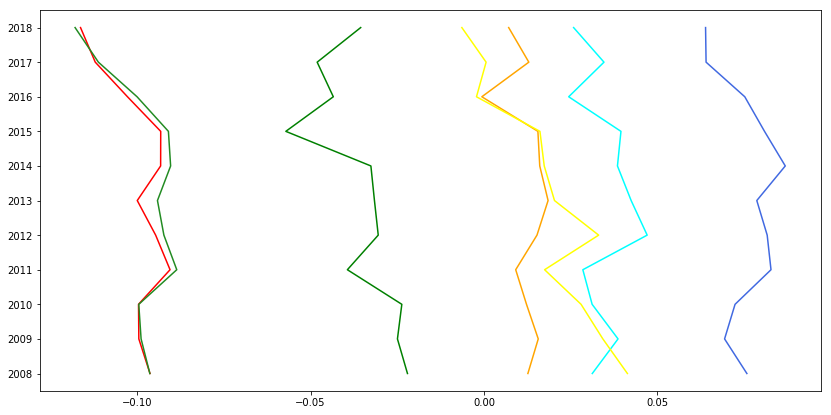

In [29]:
party_to_be_plotted = ['UDC','PSS','PDC','pvl','PLR','PES','PBD']
party_colors = ['royalblue','r', 'orange', 'g', 'cyan', 'forestgreen', 'yellow']
party_color_map = dict((key, value) for (key, value) in zip(party_to_be_plotted, party_colors))

visualize_party_orientation(party_evolution_df, years, party_color_map)


** Modularity analysis **

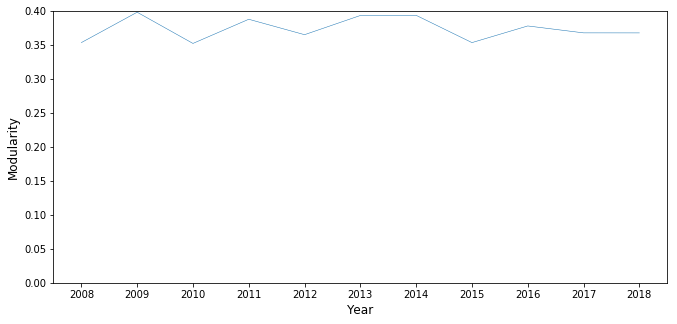

In [34]:
legislatures=['48','49','50']
years_of_leg = [4,4,3]
modularity_data, years = compute_modularity(legislatures, years_of_leg, resolution=1)
visualize_modularity(modularity_data, years)

** Community "loyalty" analysis**

In [35]:
leg = ['50']
leg_years = [3]
# Analyze for communities formed by modularity maximization
community_type = 'modularity_max'

communities, community_loyalty, node_loyalty, years = compute_community_loyalty(community_type, leg, leg_years)

C:\Users\silus\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


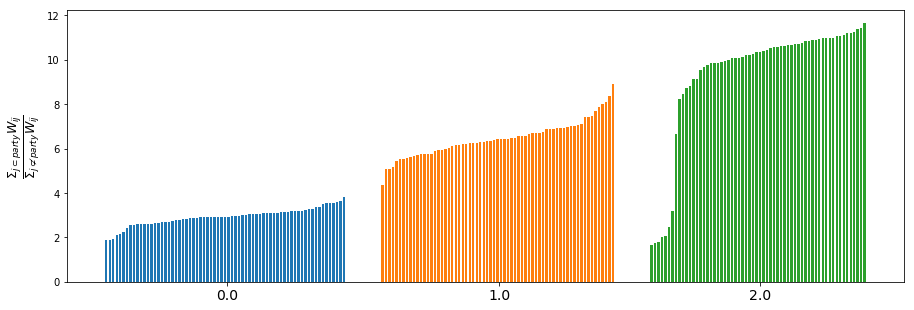

In [36]:
visualize_node_loyalty(node_loyalty[0], padding=10)

**Centrality**

In [46]:
legislatures=['48','49','50']
years_of_leg = [4,4,3]
centrality, years = centralities(legislatures, years_of_leg, 0.5)

In [49]:
centrality[0].head()

,CouncillorName,PartyAbbreviation,Closeness centrality,Betweenness centrality
0,Bruderer Wyss Pascale,PSS,0.485075,0.014283
1,Parmelin Guy,UDC,0.502577,0.019637
2,Germanier Jean-René,PLR,0.580357,0.002626
3,Engelberger Edi,PLR,0.592705,0.009219
4,Müller Geri,PES,0.372849,0.000001


**Party isolation analysis**